In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 10

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [70]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.001, 2000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 2000: PDE Error: 0.106316738584; False Transient Error: 0.106308387133; Iterations: 41; CG Error: 0.000000000096
Episode 2000: PDE Error: 0.106316443121; False Transient Error: 0.106308095780; Iterations: 41; CG Error: 0.000000000093
Episode 2000: PDE Error: 0.106312247172; False Transient Error: 0.106303879695; Iterations: 41; CG Error: 0.000000000074
Episode 2000: PDE Error: 0.106310961576; False Transient Error: 0.106302585376; Iterations: 41; CG Error: 0.000000000072
Episode 2000: PDE Error: 0.106315621437; False Transient Error: 0.106307290002; Iterations: 41; CG Error: 0.000000000086
Episode 2000: PDE Error: 0.106317121570; False Transient Error: 0.106308809217; Iterations: 42; CG Error: 0.000000000090
Episode 2000: PDE Error: 0.106316959630; False Transient Error: 0.106308627221; Iterations: 42; CG Error: 0.000000000074
Episode 2000: PDE Error: 0.106314130714; False Transient Error: 0.106305790287; Iterations: 41; CG Error: 0.000000000079
Episode 2000: PDE Error: 0.10631

In [4]:
# np.save(f"v_list_{λ}", ϕ_list)
# np.save(f"e_list_{λ}", ems_list)
ems_list = np.load("e_list_10.npy")
ϕ_list = np.load("v_list_10.npy")

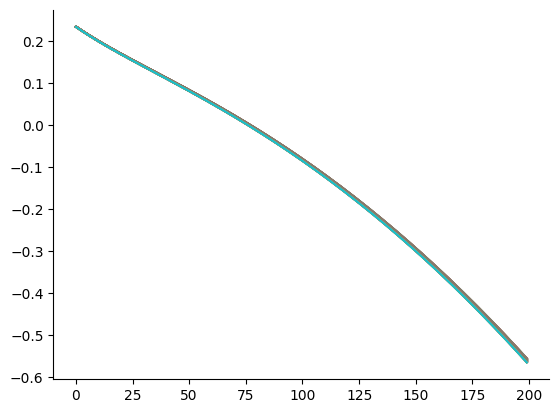

In [5]:
plt.plot(ϕ_list[0])
plt.show()

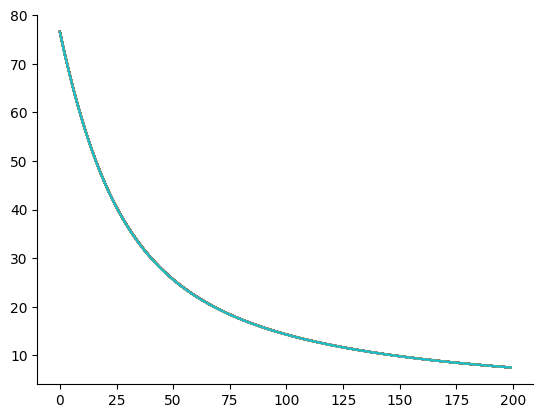

In [6]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

$$
\log N = \begin{cases} 
\gamma_1 y_1 + \frac{\gamma_2}{2} y_1 ^2, \text{ if } y_1 \le \tilde{y_1} \\
\gamma_1 (y_1 - \tilde{y_1} + \bar{y_1}) + \frac{\gamma_2}{2} (y_1 - \tilde{y_1} + \bar{y_1})^2
+ \frac{\gamma_3}{2} (y_1 - \tilde{y_1})^2, \text{ if } y_1 \geq \tilde{y_1} \end{cases}
$$

In [ ]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1.
ϵ = 0.001
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
gm_old =πd_o
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 1. + ems_old * 0.
    #     print(np.min(ems))
    g_m_new = np.exp(1 / ξp * (v0 - v_m))
    g_m = g_m_new*1. + gm_old*0.
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    gm_old = g_m
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.156001539049	 rhs error: 0.157321870915
Episode: 2	 lhs error: 0.152851833881	 rhs error: 0.154427785797
Episode: 3	 lhs error: 0.153151010294	 rhs error: 0.153678306890
Episode: 4	 lhs error: 0.146330713241	 rhs error: 0.152969284555
Episode: 5	 lhs error: 0.151704679329	 rhs error: 0.152294375661
Episode: 6	 lhs error: 0.159067688064	 rhs error: 0.151592005485
Episode: 7	 lhs error: 0.150765663823	 rhs error: 0.150860142498
Episode: 8	 lhs error: 0.147692113148	 rhs error: 0.150178017565
Episode: 9	 lhs error: 0.147174582590	 rhs error: 0.149513785916
Episode: 10	 lhs error: 0.146410574506	 rhs error: 0.148856657831
Episode: 11	 lhs error: 0.143238272681	 rhs error: 0.148208667967
Episode: 12	 lhs error: 0.148091244641	 rhs error: 0.147575368393
Episode: 13	 lhs error: 0.147534958893	 rhs error: 0.146922194939
Episode: 14	 lhs error: 0.146804148539	 rhs error: 0.146274858224
Episode: 15	 lhs error: 0.141837934475	 rhs error: 0.145637427834
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.135614647227	 rhs error: 0.143007258220
Episode: 126	 lhs error: 0.136652859237	 rhs error: 0.139819663864
Episode: 127	 lhs error: 0.136784881506	 rhs error: 0.137386859102
Episode: 128	 lhs error: 0.130233295001	 rhs error: 0.135178070651
Episode: 129	 lhs error: 0.127637309175	 rhs error: 0.134231212236
Episode: 130	 lhs error: 0.134227574664	 rhs error: 0.134165844606
Episode: 131	 lhs error: 0.132857302488	 rhs error: 0.134087973195
Episode: 132	 lhs error: 0.128640853533	 rhs error: 0.162078327534
Episode: 133	 lhs error: 1.095238888401	 rhs error: 1.107387517514
Episode: 134	 lhs error: 1.069525527685	 rhs error: 1.122033753173
Episode: 135	 lhs error: 1.129812991363	 rhs error: 1.126977629636
Episode: 136	 lhs error: 1.147527035147	 rhs error: 1.172099873754
Episode: 137	 lhs error: 1.157629024197	 rhs error: 1.189843083864
Episode: 138	 lhs error: 1.170264046362	 rhs error: 1.202410285327
Episode: 139	 lhs error: 1.181010627436	 rhs error: 1.21236682

Episode: 248	 lhs error: 1.180279455620	 rhs error: 1.210746121437
Episode: 249	 lhs error: 1.192790954803	 rhs error: 1.221826567782
Episode: 250	 lhs error: 1.206149797680	 rhs error: 1.233210647231
Episode: 251	 lhs error: 1.219261380588	 rhs error: 1.381074165901
Episode: 252	 lhs error: 1.229488724120	 rhs error: 1.455126744524
Episode: 253	 lhs error: 1.243451039855	 rhs error: 1.493020285631
Episode: 254	 lhs error: 1.255299576882	 rhs error: 1.516746640347
Episode: 255	 lhs error: 1.288117605529	 rhs error: 1.530150192269
Episode: 256	 lhs error: 1.287910962169	 rhs error: 1.537963009387
Episode: 257	 lhs error: 1.299831437571	 rhs error: 1.550947162448
Episode: 258	 lhs error: 1.307535066938	 rhs error: 1.561947487909
Episode: 259	 lhs error: 1.325677315067	 rhs error: 1.572338006335
Episode: 260	 lhs error: 1.332980080313	 rhs error: 1.580959724352
Episode: 261	 lhs error: 1.343893711488	 rhs error: 1.586306960358
Episode: 262	 lhs error: 1.354212368473	 rhs error: 1.60186451

Episode: 371	 lhs error: 1.435426336217	 rhs error: 1.491495695361
Episode: 372	 lhs error: 1.442834621944	 rhs error: 1.508859348467
Episode: 373	 lhs error: 1.461998582048	 rhs error: 1.525800258631
Episode: 374	 lhs error: 1.463897910972	 rhs error: 1.546637639771
Episode: 375	 lhs error: 1.463790221555	 rhs error: 1.562140928762
Episode: 376	 lhs error: 1.496783035418	 rhs error: 1.576952483253
Episode: 377	 lhs error: 1.502534291450	 rhs error: 1.603482477650
Episode: 378	 lhs error: 1.516413392176	 rhs error: 1.620694021731
Episode: 379	 lhs error: 1.498310560834	 rhs error: 1.641105593694
Episode: 380	 lhs error: 1.529696086288	 rhs error: 1.649547784494
Episode: 381	 lhs error: 1.541059809939	 rhs error: 1.677022286545
Episode: 382	 lhs error: 1.559242391135	 rhs error: 1.697103005173
Episode: 383	 lhs error: 1.557926636310	 rhs error: 1.720206845160
Episode: 384	 lhs error: 1.568037076727	 rhs error: 1.735419798395
Episode: 385	 lhs error: 1.595816887383	 rhs error: 1.75552885

Episode: 494	 lhs error: 0.138254125980	 rhs error: 0.148028081853
Episode: 495	 lhs error: 0.138463295152	 rhs error: 0.158305252474
Episode: 496	 lhs error: 0.132983743739	 rhs error: 0.154287415287
Episode: 497	 lhs error: 0.132169977463	 rhs error: 0.186601158095
Episode: 498	 lhs error: 0.136590892742	 rhs error: 0.151760929347
Episode: 499	 lhs error: 0.703864738310	 rhs error: 1.116676431252
Episode: 500	 lhs error: 0.890534977643	 rhs error: 1.388768225074
Episode: 501	 lhs error: 0.977982374101	 rhs error: 1.467348319311
Episode: 502	 lhs error: 1.007176875108	 rhs error: 1.510020989666
Episode: 503	 lhs error: 1.012884821656	 rhs error: 1.531968844252
Episode: 504	 lhs error: 1.007427106338	 rhs error: 1.544204006030
Episode: 505	 lhs error: 1.006185313773	 rhs error: 1.553254674447
Episode: 506	 lhs error: 1.001771973826	 rhs error: 1.564019347118
Episode: 507	 lhs error: 0.998722455677	 rhs error: 1.572301690041
Episode: 508	 lhs error: 1.000231305445	 rhs error: 1.58107246

Episode: 617	 lhs error: 1.053642691428	 rhs error: 1.482724440004
Episode: 618	 lhs error: 1.027509169847	 rhs error: 1.486586974025
Episode: 619	 lhs error: 1.027997760118	 rhs error: 1.495522314318
Episode: 620	 lhs error: 1.027882823220	 rhs error: 1.505198202376
Episode: 621	 lhs error: 1.025571032706	 rhs error: 1.517488623401
Episode: 622	 lhs error: 1.023000480429	 rhs error: 1.526618628642
Episode: 623	 lhs error: 1.017980550835	 rhs error: 1.534303056757
Episode: 624	 lhs error: 1.014880360014	 rhs error: 1.526075734081
Episode: 625	 lhs error: 1.037445111520	 rhs error: 1.536307106904
Episode: 626	 lhs error: 1.427623753534	 rhs error: 1.569405730235
Episode: 627	 lhs error: 1.463960296377	 rhs error: 1.736963226981
Episode: 628	 lhs error: 1.649149904040	 rhs error: 1.906752563895
Episode: 629	 lhs error: 1.452877390507	 rhs error: 1.677075217867
Episode: 630	 lhs error: 1.037521956368	 rhs error: 1.585540961238
Episode: 631	 lhs error: 1.029897350265	 rhs error: 1.59498208

Episode: 740	 lhs error: 1.362039559345	 rhs error: 1.581859637699
Episode: 741	 lhs error: 1.384384498432	 rhs error: 1.544294460153
Episode: 742	 lhs error: 1.399268906743	 rhs error: 1.436417794284
Episode: 743	 lhs error: 1.401174592926	 rhs error: 1.454483049841
Episode: 744	 lhs error: 1.427643375019	 rhs error: 1.469254452293
Episode: 745	 lhs error: 1.441914540406	 rhs error: 1.491154624351
Episode: 746	 lhs error: 1.446036667515	 rhs error: 1.509983215751
Episode: 747	 lhs error: 1.454895041268	 rhs error: 1.525869670193
Episode: 748	 lhs error: 1.475265652931	 rhs error: 1.543442044220
Episode: 749	 lhs error: 1.487216273874	 rhs error: 1.564971712712
Episode: 750	 lhs error: 1.484007098486	 rhs error: 1.583973064239
Episode: 751	 lhs error: 1.520791699484	 rhs error: 1.597885115939
Episode: 752	 lhs error: 1.540991558333	 rhs error: 1.626303707809
Episode: 753	 lhs error: 1.512782068610	 rhs error: 1.649242539176
Episode: 754	 lhs error: 1.540130554189	 rhs error: 1.65403635

Episode: 863	 lhs error: 1.447166917861	 rhs error: 1.533426263335
Episode: 864	 lhs error: 1.463656201340	 rhs error: 1.553666968596
Episode: 865	 lhs error: 1.480322647957	 rhs error: 1.574433532032
Episode: 866	 lhs error: 1.480924720553	 rhs error: 1.595703789738
Episode: 867	 lhs error: 1.516114898446	 rhs error: 1.611701040630
Episode: 868	 lhs error: 1.512911718402	 rhs error: 1.640065804897
Episode: 869	 lhs error: 1.511289032540	 rhs error: 1.655077491845
Episode: 870	 lhs error: 1.530775750839	 rhs error: 1.670578108301
Episode: 871	 lhs error: 1.559190778771	 rhs error: 1.694198885886
Episode: 872	 lhs error: 1.555792587639	 rhs error: 1.721745227396
Episode: 873	 lhs error: 1.572824052837	 rhs error: 1.736996439579
Episode: 874	 lhs error: 1.572147038330	 rhs error: 1.760616942358
Episode: 875	 lhs error: 1.580187480597	 rhs error: 1.777072067089
Episode: 876	 lhs error: 1.598730605283	 rhs error: 1.797280799248
Episode: 877	 lhs error: 1.613072586886	 rhs error: 1.82233771

Episode: 986	 lhs error: 1.460937742539	 rhs error: 1.532961157767
Episode: 987	 lhs error: 1.470814489731	 rhs error: 1.554596346066
Episode: 988	 lhs error: 1.486174305762	 rhs error: 1.573162250747
Episode: 989	 lhs error: 1.506655644155	 rhs error: 1.593796862965
Episode: 990	 lhs error: 1.490982070505	 rhs error: 1.616508377091
Episode: 991	 lhs error: 1.524501947305	 rhs error: 1.626759649384
Episode: 992	 lhs error: 1.507263821551	 rhs error: 1.654606747037
Episode: 993	 lhs error: 1.547160718009	 rhs error: 1.664248185862
Episode: 994	 lhs error: 1.538944221168	 rhs error: 1.695344581301
Episode: 995	 lhs error: 1.532718838814	 rhs error: 1.708440196689
Episode: 996	 lhs error: 1.579368389099	 rhs error: 1.722101450358
Episode: 997	 lhs error: 1.584772777763	 rhs error: 1.757461502005
Episode: 998	 lhs error: 1.569803698037	 rhs error: 1.776372691328
Episode: 999	 lhs error: 1.593176388717	 rhs error: 1.786573836153
Episode: 1000	 lhs error: 1.608700230173	 rhs error: 1.8134180

Episode: 1107	 lhs error: 1.147862119920	 rhs error: 1.671638067274
Episode: 1108	 lhs error: 1.143312985082	 rhs error: 1.672829514045
Episode: 1109	 lhs error: 1.284845596140	 rhs error: 1.674032449980
Episode: 1110	 lhs error: 1.434479059714	 rhs error: 1.675296223180
Episode: 1111	 lhs error: 1.512272516963	 rhs error: 1.743916908948
Episode: 1112	 lhs error: 1.547281746967	 rhs error: 1.792017958763
Episode: 1113	 lhs error: 1.540834348412	 rhs error: 1.823292715527
Episode: 1114	 lhs error: 1.583957914856	 rhs error: 1.836702212279
Episode: 1115	 lhs error: 1.587263400826	 rhs error: 1.867154903731
Episode: 1116	 lhs error: 1.563356979013	 rhs error: 1.822189608237
Episode: 1117	 lhs error: 1.165825182928	 rhs error: 1.685954920117
Episode: 1118	 lhs error: 1.106590618818	 rhs error: 1.687603843838
Episode: 1119	 lhs error: 1.106746405007	 rhs error: 1.689272346894
Episode: 1120	 lhs error: 1.609400091305	 rhs error: 1.690988443817
Episode: 1121	 lhs error: 1.519206717225	 rhs er

In [11]:
v_guess = v0
ems_guess = ems

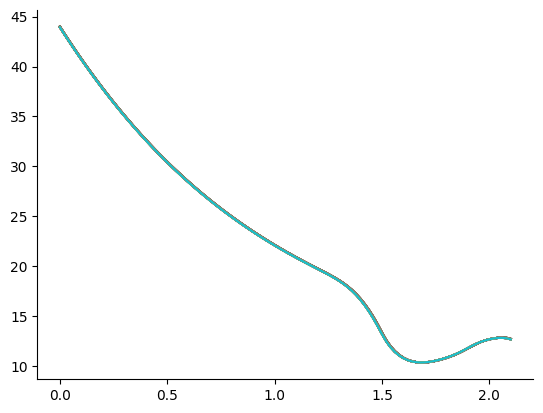

In [15]:
plt.plot(y1_grid_cap, ems)
plt.show()

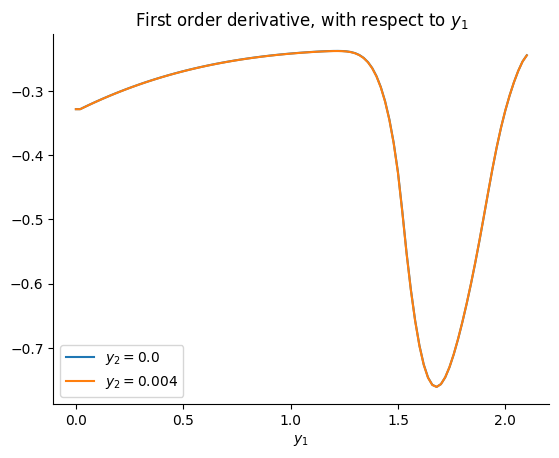

In [16]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

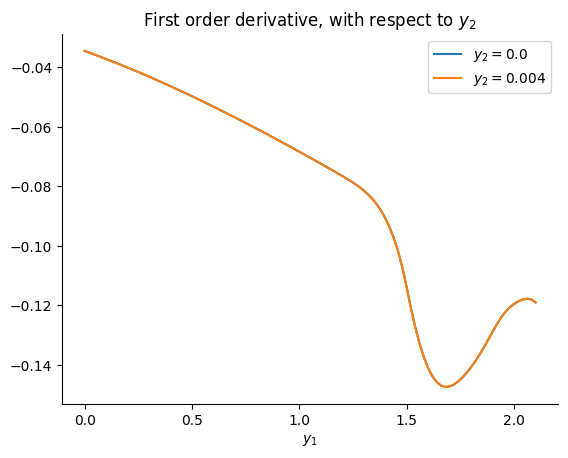

In [17]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

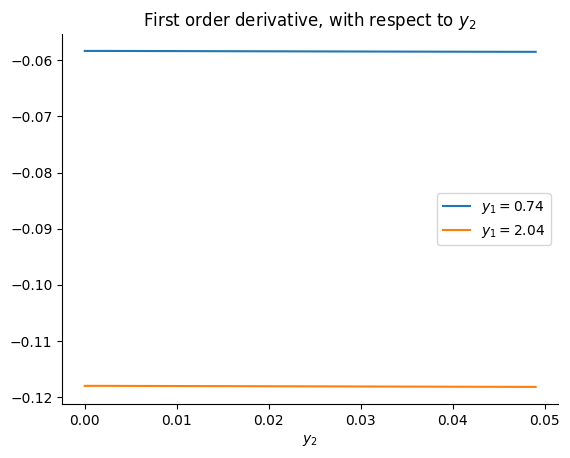

In [18]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

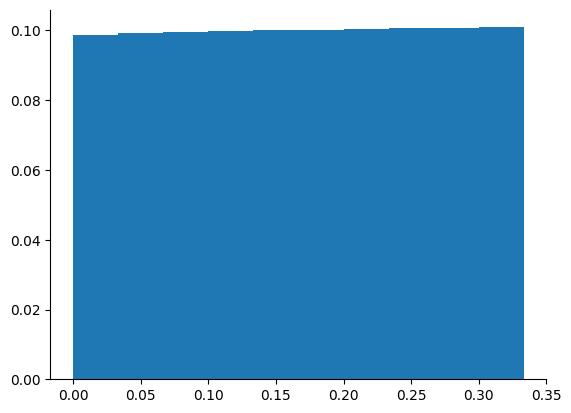

In [19]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

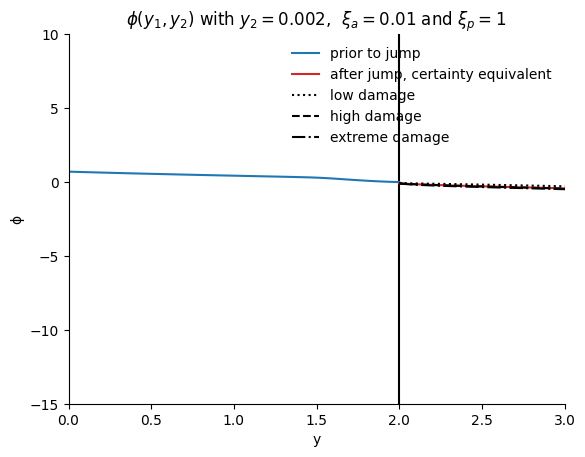

In [20]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

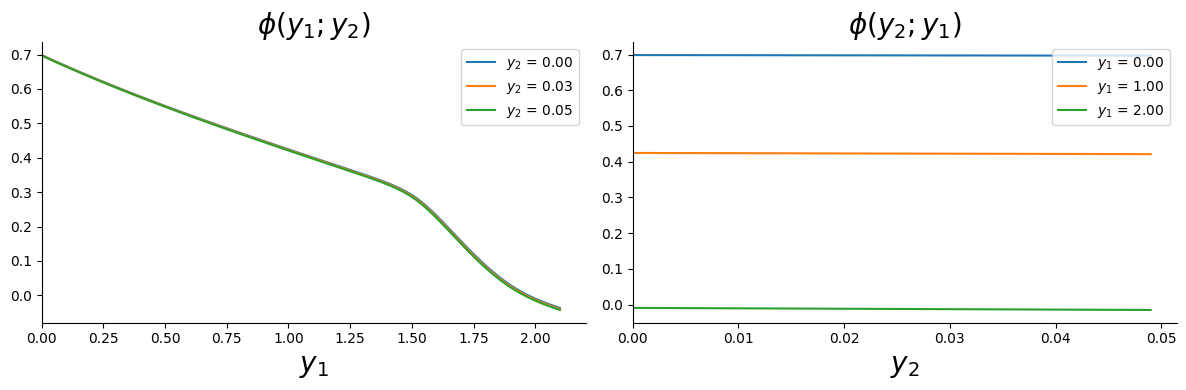

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

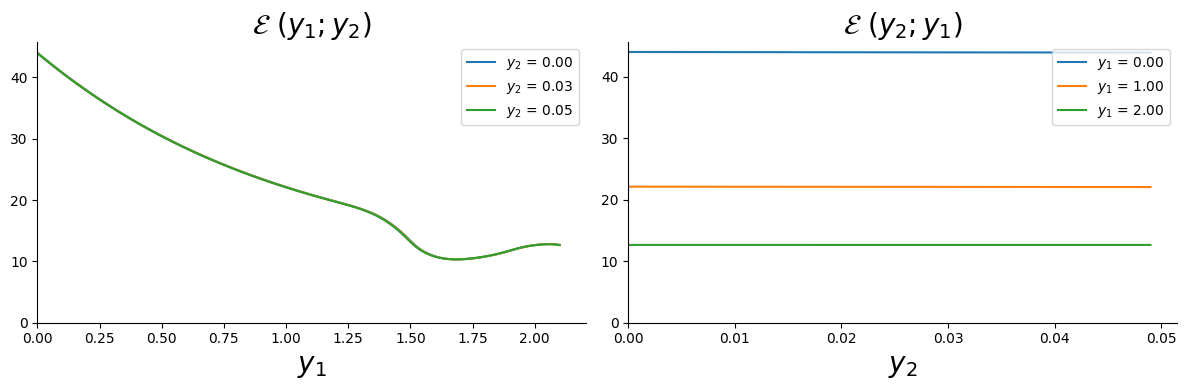

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [23]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [24]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [25]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [26]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [27]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

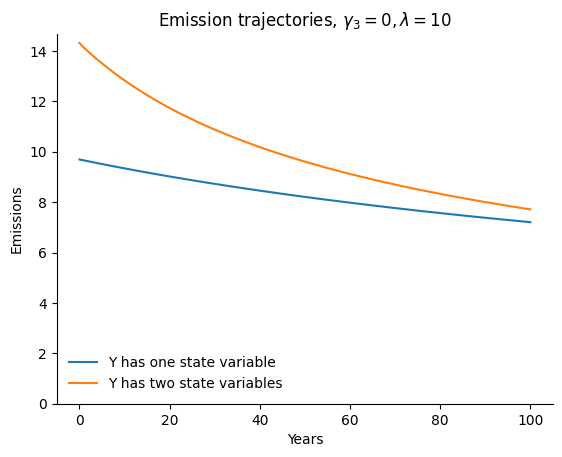

In [28]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [29]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=36
                                                 )

In [30]:
y1t_prejump

array([1.1       , 1.13888626, 1.17685827, 1.21404051, 1.25045866,
       1.28611168, 1.32095501, 1.35488747, 1.38772645, 1.41925439,
       1.44925519, 1.47749223, 1.50382792, 1.52822327, 1.55104289,
       1.57272136, 1.59356693, 1.61380753, 1.63361757, 1.65313453,
       1.67246952, 1.69171408, 1.71094447, 1.73022461, 1.74960814,
       1.76914032, 1.78886029, 1.80880401, 1.82900793, 1.84951261,
       1.8703647 , 1.89161454, 1.91330672, 1.93546469, 1.95807631,
       1.98109167, 2.00443372])

In [31]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

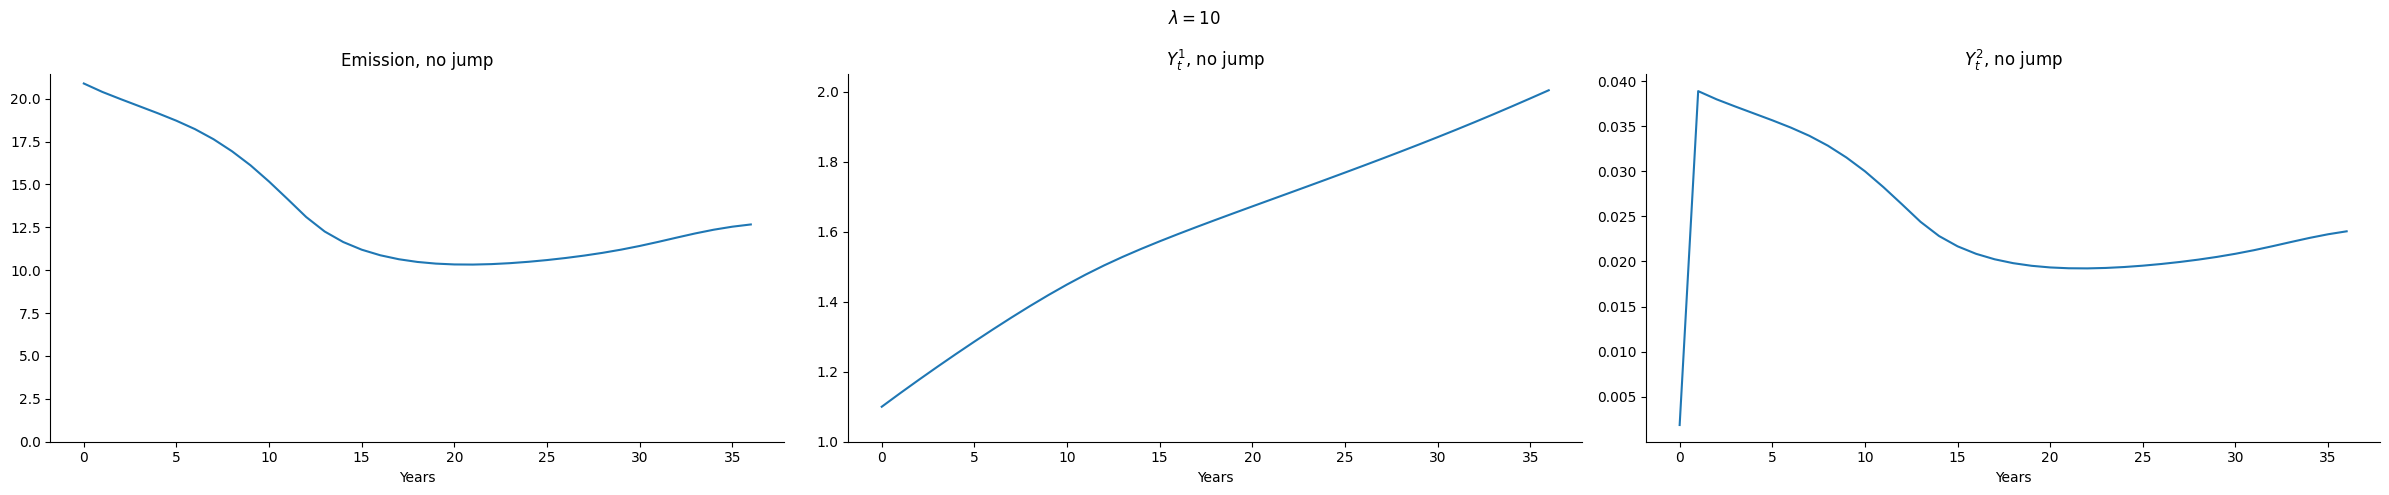

In [32]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$, no jump")
plt.plot(y2t_prejump)
# plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [33]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [34]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.03888625693660049,
 0.049,
 array([1.1       , 1.13888626, 1.17685827, 1.21404051, 1.25045866,
        1.28611168, 1.32095501, 1.35488747, 1.38772645, 1.41925439,
        1.44925519, 1.47749223, 1.50382792, 1.52822327, 1.55104289,
        1.57272136, 1.59356693, 1.61380753, 1.63361757, 1.65313453,
        1.67246952, 1.69171408, 1.71094447, 1.73022461, 1.74960814,
        1.76914032, 1.78886029, 1.80880401, 1.82900793, 1.84951261,
        1.8703647 , 1.89161454, 1.91330672, 1.93546469, 1.95807631,
        1.98109167, 2.00443372]))

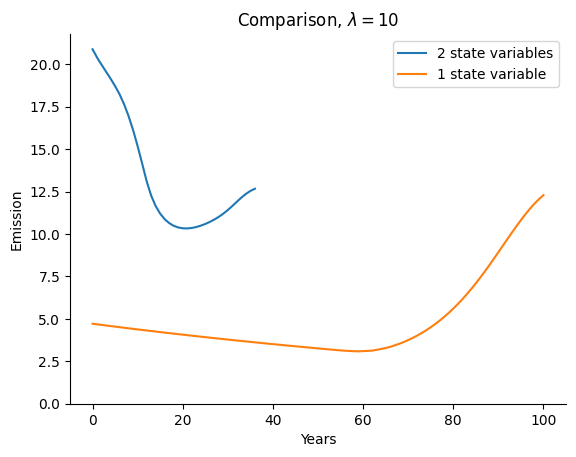

In [35]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [36]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [37]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [39]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=37)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

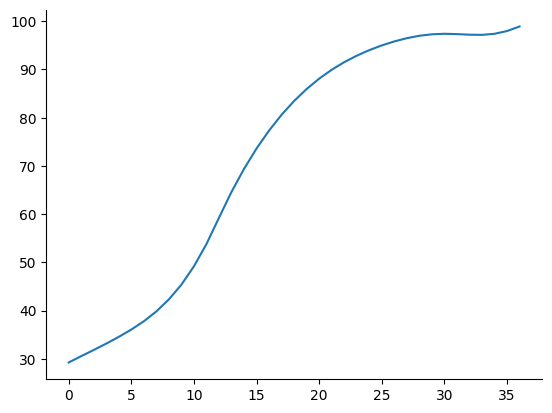

In [40]:
plt.plot(scc)
plt.show()

In [41]:
np.save(f"scct_{λ}", scc)